
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [16]:
%cd C:/A/GitHub/reference_study/MMdection

C:\A\GitHub\reference_study\MMdection


## Prepare data

In [17]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "C:/A/VinBigData/data_png_512"



convert_to_coco 에서 train image도 jpg로 저장하도록 했습니다.

In [ ]:
def convert_to_coco(
    json_paths, # 변경
    save_path,
)
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)
            

        # [추가 ] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(base_dir, "train_img", tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, w, h],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)

In [4]:
save_path_dir = os.path.join(base_dir, "train_img")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir

'C:/A/VinBigData/data_png_512\\train_img'

In [ ]:
random.seed(10)

train_files = glob(os.path.join(base_dir, 'train/*.json'))

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

In [ ]:
convert_to_coco(train_file, os.path.join(base_dir, 'train_annotations.json'))

In [ ]:
convert_to_coco(valid_file, os.path.join(base_dir, 'valid_annotations.json'))

test image 저장

In [ ]:
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))

In [ ]:
save_path_dir = os.path.join(base_dir, "test_img")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(base_dir, "test_img", image_id+".jpg"))
    

## Environment setting

In [18]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


'gcc'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [19]:
!pip show torch

Name: torch
Version: 1.10.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\users\wew12\anaconda3\envs\md\lib\site-packages
Requires: typing_extensions
Required-by: effdet, torchaudio, torchvision


In [7]:

# latest installation with pytorch Ref : https://mmcv.readthedocs.io/en/latest/get_started/installation.html
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git


'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


c:\A\GitHub\reference_study\MMdection\mmdetection


Cloning into 'mmdetection'...


In [20]:
%cd mmdetection

C:\A\GitHub\reference_study\MMdection\mmdetection


In [21]:
!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

런타임 다시 시작하고 진행합니다.

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

c:\Users\wew12\Anaconda3\envs\md\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.0 True
2.25.2
11.3
MSVC 192829924


tutorial에 있는 mask_rcnn 모델을 그대로 사용해도 되지만 저는 faster_rcnn 모델을 사용했습니다.

In [2]:
%cd mmdetection


c:\A\GitHub\reference_study\MMdection\mmdetection


In [2]:
# %cd mmdetection
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
#       -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
      -O checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

c:\A\GitHub\reference_study\MMdection\mmdetection


--2022-10-17 16:46:13--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.32
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

     0K .......... .......... .......... .......... ..........  0%  676K 4m2s
    50K .......... .......... .......... .......... ..........  0% 1.18M 3m9s
   100K .......... .......... .......... .......... ..........  0% 2.20M 2m30s
   150K .......... .......... .......... .......... ..........  0% 2.78M 2m7s
   200K .......... .......... .......... .......... ..........  0% 2.75M 1m53s
   250K .......... .......... .......... .......... ..........  0% 3.42M 1m42s
   300K .......... ......

In [3]:
# Choose to use a config and initialize the detector
config = "configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py"
# Setup a checkpoint file to load
checkpoint = '/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# initialize the detector
#model = init_detector(config, checkpoint, device='cuda:0')

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [4]:
import mmcv
import matplotlib.pyplot as plt

import copy
import os.path as osp

import mmcv
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [5]:
from mmcv import Config
cfg = Config.fromfile(config)

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [6]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "C:/A/VinBigData/data_png_512"



In [7]:
save_path_dir = os.path.join(base_dir, "train_img")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

In [8]:
from mmdet.apis import set_random_seed

base_path = "C:/A/VinBigData/Chest_X-ray_512" # base_dir과 같습니다.

test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"

test_img =  "train_img" # 출력은 "train_100000"
train_img = "train_img" # 출력은 "train_100000"


save_dir = os.path.join(base_path,"work_dir")


In [14]:
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

# test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img

# train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

# val
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = test_anno
cfg.data.val.img_prefix = test_img

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = ('Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity','Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening','Pneumothorax','Pulmonary fibrosis')

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 4
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = "./checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth" # Error가 날 경우, "/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth"

# Set up working dir to save files and logs.
cfg.work_dir = save_dir

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=2)

cfg.log_config.interval = 2

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda' 


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [15]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


2022-10-17 21:51:35,826 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


FileNotFoundError: CocoDataset: [Errno 2] No such file or directory: 'C:/A/VinBigData/Chest_X-ray_512\\valid_annotations.json'

## Test the trained detector

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test_img")

test_file = glob(test_img+"/*.jpg")

In [ ]:
len(test_file), test_file[0]

(20874,
 '/content/drive/MyDrive/병변_검출_AI_경진대회/test_img/test_219874.jpg')

테스트 데이터 하나를 추론해봅니다.

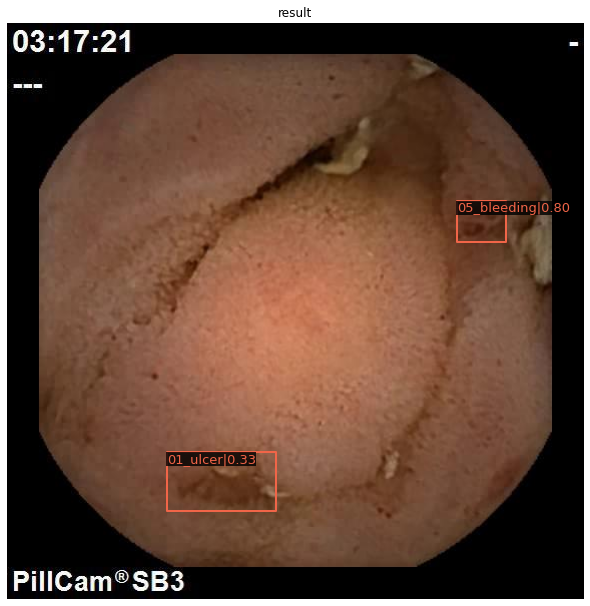

In [ ]:

img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


predictions의 길이는 4입니다. 이 4는 class의 개수를 의미하며
config에서 지정해준 순서대로, 즉 간단한 이름으로 01, 02, 04, 05를 나타냅니다.

따라서, 아래와 같은 경우 6개의 01 라벨과 5개의 05 라벨이 탐지되었다는 의미입니다.

하지만 위 사진을 보면 두 개만 시각화되었는데 11개의 탐지된 결과 중 기본 지정 threshold인 0.3을 넘는 데이터가 두 개 뿐이었기 때문입니다.

각 탐지된 결과는 5개의 element를 갖는데 앞의 4개가 bbox 좌표(x_min, y_min, x_max, y_max), 마지막 하나가 score(confidence)입니다.



In [ ]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,

(4, (6, 5), (0, 5), (0, 5), (5, 5))

01 라벨의 스코어들을 보니 가장 첫 번째 탐지 결과만 살아남아 시각화된 걸 알 수 있습니다.

In [ ]:
result[0]

array([[1.5917267e+02, 4.2937466e+02, 2.6868179e+02, 4.8890247e+02,
        3.2913455e-01],
       [4.9998013e+02, 1.5651205e+02, 5.4743506e+02, 2.7698334e+02,
        2.1879849e-01],
       [4.4588776e+02, 1.4019687e+02, 5.4666516e+02, 2.9086475e+02,
        2.1190903e-01],
       [3.8568039e+02, 2.9986437e+01, 4.3603452e+02, 6.5169594e+01,
        9.6010163e-02],
       [3.3896964e+02, 4.0794598e+02, 4.1592007e+02, 5.0344107e+02,
        8.1990764e-02],
       [3.5239062e+02, 4.1403925e+02, 4.0816681e+02, 4.7321021e+02,
        6.4823367e-02]], dtype=float32)

05 라벨의 스코어들을 보니 이것 또한 가장 첫 번째 탐지 결과만 살아남은 것을 알 수 있습니다.

In [ ]:
result[-1]

array([[4.4998047e+02, 1.7842303e+02, 4.9829413e+02, 2.1949487e+02,
        7.9846215e-01],
       [4.3630359e+02, 1.6521832e+02, 5.0571652e+02, 2.2400267e+02,
        1.6335534e-01],
       [4.6084045e+02, 4.2962192e+02, 5.1957819e+02, 4.9469543e+02,
        1.2298273e-01],
       [4.5412024e+02, 1.7302559e+02, 5.1517371e+02, 2.3556165e+02,
        9.2750356e-02],
       [4.4682004e+02, 1.6182854e+02, 5.2921564e+02, 2.6414096e+02,
        7.1121991e-02]], dtype=float32)

모든 테스트 데이터에 대해 추론을 진행합니다.

In [ ]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21

results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}

score_threshold = 0.4 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
   
for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    
    file_name = img_path.split("/")[-1].split(".")[0]+".json"

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]

        for label, score, bbox in zip(labels, scores, boxes):
            x_min, y_min, x_max, y_max = bbox.astype(np.int64)

            results['file_name'].append(file_name)
            results['class_id'].append(label)
            results['confidence'].append(score)
            results['point1_x'].append(x_min)
            results['point1_y'].append(y_min)
            results['point2_x'].append(x_max)
            results['point2_y'].append(y_min)
            results['point3_x'].append(x_max)
            results['point3_y'].append(y_max)
            results['point4_x'].append(x_min)
            results['point4_y'].append(y_max)

  0%|          | 0/20874 [00:00<?, ?it/s]

##Inference

In [ ]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(25669, 11)

In [ ]:
submission.head()

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_219874.json,1,0.897241,210,273,304,273,304,363,210,363
1,test_219874.json,1,0.471164,242,121,293,121,293,174,242,174
2,test_219875.json,1,0.537852,52,261,139,261,139,320,52,320
3,test_219875.json,1,0.482125,226,87,318,87,318,200,226,200
4,test_219875.json,2,0.899356,0,107,75,107,75,210,0,210


In [ ]:
submission.to_csv('mmdedtection_baseline.csv', index=False)